# import

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import seaborn as sns
import xgboost as xgb
import time

%matplotlib inline

# load data

## naive features
1. 生成df_all
2. 从df_all中删除以下属性price_doc

In [17]:
# From here: https://www.kaggle.com/robertoruiz/sberbank-russian-housing-market/dealing-with-multicollinearity/notebook
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

df_train = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')

# 更新price_doc
price_doc_oof = pd.read_csv('../output/stacking/Submission-NaiveXgb-WithPredictedBuildYear-Stacking-OutOfFold.csv', index_col='id')
price_doc_pred = pd.read_csv('../output/stacking/Submission-NaiveXgb-WithPredictedBuildYear-Stacking-Test.csv', index_col='id')
df_all.set_index('id', inplace=True)
df_all.loc[df_all.index.isin(price_doc_pred.index), 'price_doc'] = price_doc_pred.price_doc
df_all.reset_index(inplace=True)

# Add month-year
# 新特征 哪年哪月（交易量）
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
# 新特征 一年中的第几周（交易量）
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
# 新特征 几月份（交易 ）和 星期几（交易）
df_all['sell_year'] = df_all.timestamp.dt.year
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
# 新特征，楼层位置，厨房面积占比
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

sub_area_map = df_all.sub_area.value_counts().to_dict()
df_all['gaoyl_subarea_cnt'] = df_all.sub_area.map(sub_area_map)

to_drop = ['gaoyl_rest_sq', 'price_doc']
# to_drop = ['gaoyl_rest_sq']
df_all.drop(filter(lambda x: x in df_all.columns, to_drop), axis=1, inplace=True)

## show build year

Missing 0.446490105346 percent in train set 30471 samples.
Missing 0.136909423127 percent in test set 7662 samples.
timestamp greater 20226
build_year greater 1789


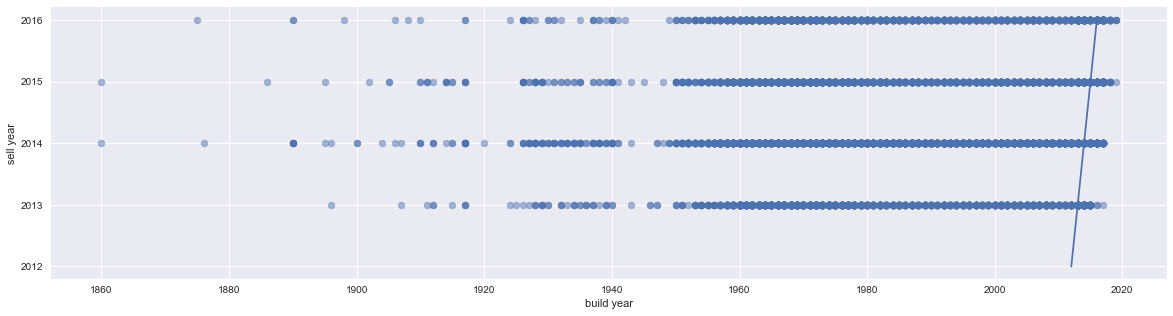

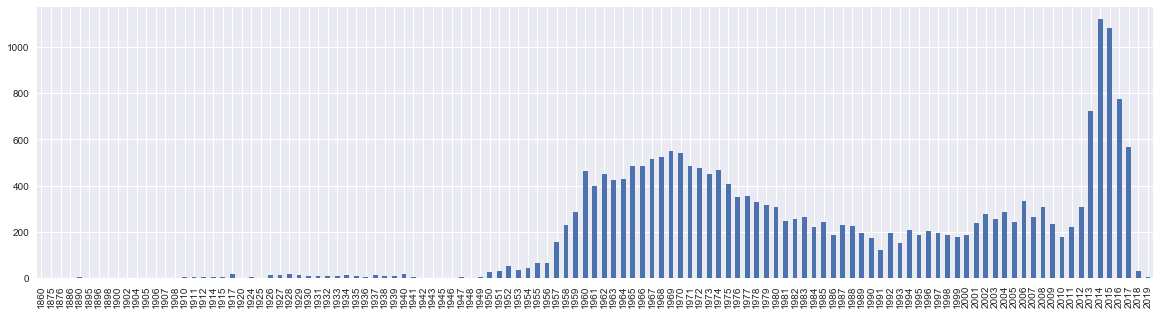

-----train-----


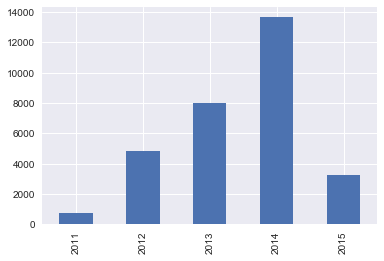

-----test-----


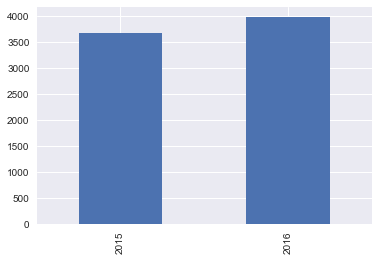

In [13]:
print 'Missing {} percent in train set {} samples.'.format(df_train.build_year.isnull().mean(), df_train.shape[0])
print 'Missing {} percent in test set {} samples.'.format(df_test.build_year.isnull().mean(), df_test.shape[0])

sell_year = df_all.loc[df_all.build_year.notnull() & (df_all.build_year < 2100) & (df_all.build_year > 1800)].timestamp.dt.year
build_year = df_all.loc[df_all.build_year.notnull() & (df_all.build_year < 2100) & (df_all.build_year > 1800)].build_year
print 'timestamp greater', np.sum(sell_year >= build_year)
# print sell_year.value_counts()
print 'build_year greater', np.sum(sell_year < build_year)
# print build_year.value_counts()
plt.figure(figsize=(20, 5))
ax = plt.gca()
plt.scatter(build_year.values, sell_year.values, alpha=.5)
yticks = [2012, 2013, 2014, 2015, 2016]
plt.plot(yticks, yticks)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
plt.xlabel('build year')
plt.ylabel('sell year')
plt.show()

plt.figure(figsize=(20, 5))
build_year.apply(int).value_counts().sort_index().plot(kind='bar')
plt.show()

print '-' * 5 + 'train' + '-' * 5
df_train.timestamp.dt.year.value_counts().sort_index().plot(kind='bar')
plt.show()
print '-' * 5 + 'test' + '-' * 5
df_test.timestamp.dt.year.value_counts().sort_index().plot(kind='bar')
plt.show()

## split train & test for build_year
1. 根据是否有合理的build_year拆分数据集，生成train\test\train_test三个dataframe
2. 生成ndarray X_train_all, y_all, X_test
3. 生成ndarray X_train, y_train, X_val, y_val

In [18]:
has_build_year = df_all.build_year.notnull() & (df_all.build_year < 2100) & (df_all.build_year > 1800)
train = df_all.loc[has_build_year].copy()
test = df_all.loc[has_build_year.apply(lambda x: not x)].copy()
print 'train {}, test {}'.format(train.shape[0], test.shape[0])

train_id = train['id']
test_id = test['id']

y_all = train.build_year

train.drop(['id', 'build_year'], axis=1, inplace=True)
test.drop(['id', 'build_year'], axis=1, inplace=True)
train_test = pd.concat([train, test])

num_train = train.shape[0]

# Deal with categorical values
# 对object类型的数据用正整数编码,这样处理后空值也有编码
df_numeric = train_test.select_dtypes(exclude=['object'])
df_obj = train_test.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

to_drop = ['timestamp']
df_values.drop(filter(lambda x: x in df_values.columns, to_drop), axis=1, inplace=True)


# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2)

X_train_all = X_all[:num_train]
X_train = X_all[:num_train-num_val]
X_val = X_all[num_train-num_val:num_train]
y_train = y_all[:-num_val]
y_val = y_all[-num_val:]

X_test = X_all[num_train:]

df_columns = df_values.columns

print('X_train_all shape is', X_train_all.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', y_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', y_val.shape)
print('X_test shape is', X_test.shape)

train 22015, test 16118
(38133L, 309L)
('X_train_all shape is', (22015L, 309L))
('X_train shape is', (17612L, 309L))
('y_train shape is', (17612L,))
('X_val shape is', (4403L, 309L))
('y_val shape is', (4403L,))
('X_test shape is', (16118L, 309L))


# xgboost single model

* naive-xgb Best iteration: [811]	val-rmse:6.87228
* with-price : [677]	val-rmse:6.9465
* with-fixed-price : [741]	val-rmse:6.8742

## best round + 20

In [26]:
dtrain_all = xgb.DMatrix(X_train_all, y_all, feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dval = xgb.DMatrix(X_val, y_val, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

xgb_params = {
    'eta': 0.05, # 0.05
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, evals=[(dval, 'val')],
                          num_boost_round=1000,
                          early_stopping_rounds=25,
                          verbose_eval=25)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:1689.49
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:31.5188
[50]	val-rmse:8.08233
[75]	val-rmse:7.67328
[100]	val-rmse:7.51144
[125]	val-rmse:7.35517
[150]	val-rmse:7.23782
[175]	val-rmse:7.16627
[200]	val-rmse:7.14312
[225]	val-rmse:7.09228
[250]	val-rmse:7.08595
Stopping. Best iteration:
[242]	val-rmse:7.059



## best round + 20 feature importance

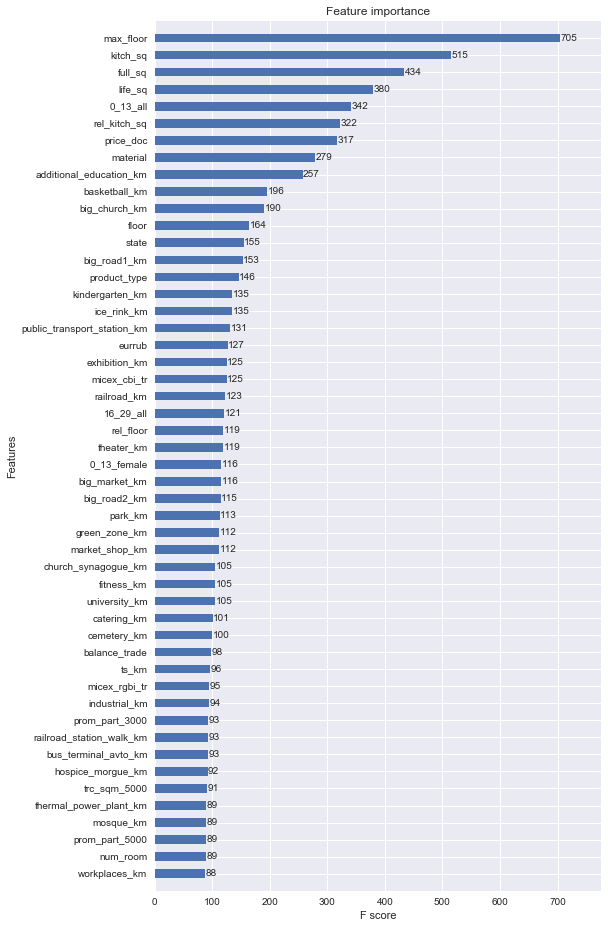

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(partial_model, max_num_features=50, height=0.5, ax=ax)

## best round

In [7]:
num_boost_round = partial_model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

## best round feature importance

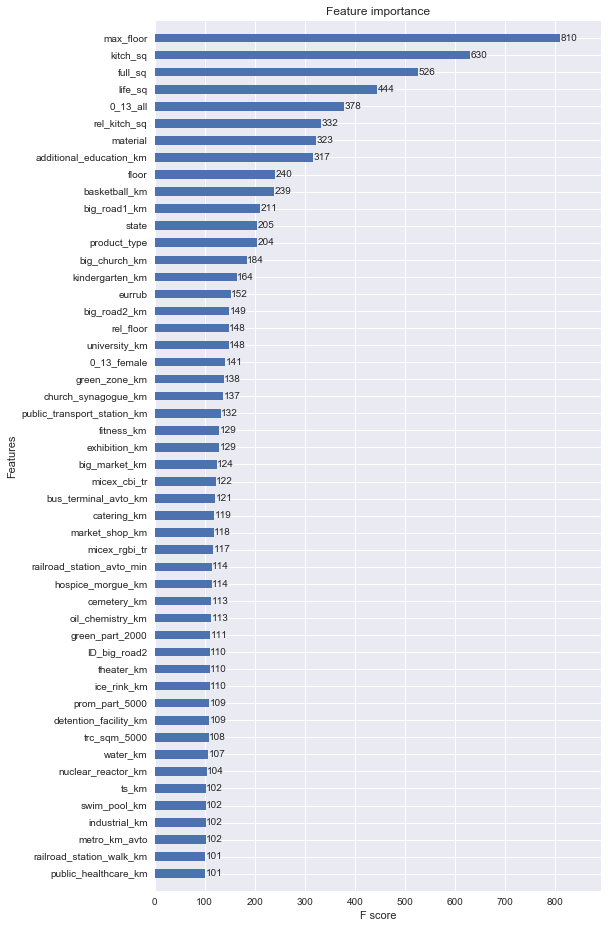

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

## predicted build_year

D:\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


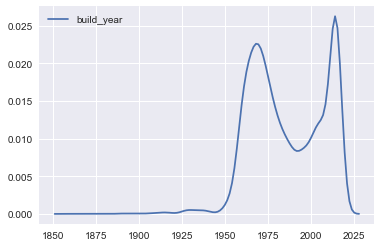

D:\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


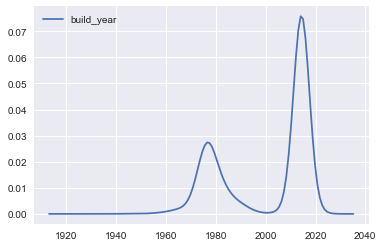

In [13]:
y_pred = model.predict(dtest)

df_pred = pd.DataFrame({'id': test_id, 'build_year': y_pred})
df_real = pd.DataFrame({'id': train_id, 'build_year': y_all.values})
df_build_year_new = pd.concat([df_real, df_pred])
df_build_year_new.to_csv('../output/feat/BuildYearNew-NaiveXgbMixture-SingleDefault2017060400-WithPrice.csv', index=False)

sns.kdeplot(y_all)
plt.show()
sns.kdeplot(df_pred.build_year)
plt.show()

# xgboost stacking @TODO

In [19]:
import sys
sys.path.append('..')
from my_py_models.stacking import Stacking
from my_py_models.my_xgb_classifier import MyXgbClassifier

In [27]:
xgb_params = {
    'eta': 0.08,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

clf = MyXgbClassifier(xgb_params)
stacking = Stacking(5, [clf])
pred_oof, pred_test = stacking.fit_predict(X_train_all, y_all, X_test)

[0]	val-rmse:1827.26
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:227.732
[50]	val-rmse:29.6881
[75]	val-rmse:8.48082
[100]	val-rmse:7.34982
[125]	val-rmse:7.14465
[150]	val-rmse:6.9988
[175]	val-rmse:6.93701
[200]	val-rmse:6.87089
[225]	val-rmse:6.83036
[250]	val-rmse:6.77467
[275]	val-rmse:6.72119
[300]	val-rmse:6.68098
[325]	val-rmse:6.65839
[350]	val-rmse:6.63992
[375]	val-rmse:6.60815
[400]	val-rmse:6.58427
[425]	val-rmse:6.55706
[450]	val-rmse:6.54322
[475]	val-rmse:6.53106
[500]	val-rmse:6.51474
[525]	val-rmse:6.4963
[550]	val-rmse:6.48813
[575]	val-rmse:6.47167
[600]	val-rmse:6.46362
[625]	val-rmse:6.45161
[650]	val-rmse:6.44043
[675]	val-rmse:6.42997
[700]	val-rmse:6.41929
[725]	val-rmse:6.41084
[750]	val-rmse:6.40904
[775]	val-rmse:6.40444
[800]	val-rmse:6.39403
[825]	val-rmse:6.38323
[850]	val-rmse:6.37758
Stopping. Best iteration:
[849]	val-rmse:6.37737

[0]	val-rmse:1827.4
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:227.79

## oof validation

In [29]:
from sklearn.metrics import mean_squared_error

print pred_oof.shape
print pred_test.shape

for pred_oof_single in pred_oof.T:
    print np.sqrt(mean_squared_error(pred_oof_single, y_all))

(22015L, 1L)
(16118L, 1L)
6.23232357938


## show oof

D:\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


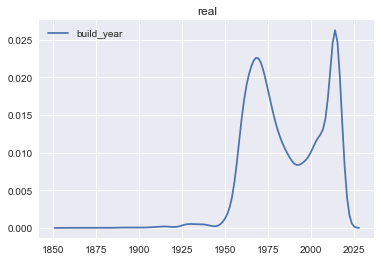

D:\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


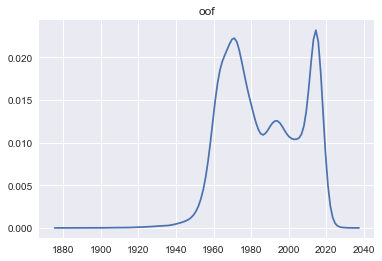

D:\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


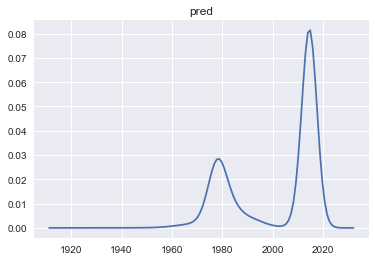

In [33]:
sns.kdeplot(y_all)
plt.title('real')
plt.show()
sns.kdeplot(pred_oof[:, 0])
plt.title('oof')
plt.show()
sns.kdeplot(pred_test[:, 0])
plt.title('pred')
plt.show()

## save stacking prediction

In [41]:
df_real = pd.DataFrame({'id': train_id, 'build_year': y_all.values})
df_real.to_csv('../output/feat/BuildYear-Real.csv', index=False)

df_pred = pd.DataFrame({'id': test_id, 'price_doc': pred_test[:, 0]})
df_pred.to_csv('../output/feat/BuildYear-NaiveXgb-Stacking-Test-2017060400.csv', index=False)

df_oof = pd.DataFrame({'id': train_id, 'price_doc': pred_oof[:, 0]})
df_oof.to_csv('../output/feat/BuildYear-NaiveXgb-Stacking-OutOfFold-2017060400.csv', index=False)